<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/PINN_assisted_4D_Var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PINN-Assisted 4D-Var for 1D Shallow-Water

[ep 0000] total=4.604e+02  phys=1.38e+01  obs=4.47e+02  reg=7.97e-11
[ep 0100] total=2.253e+01  phys=1.23e+00  obs=2.13e+01  reg=3.96e-12
[ep 0200] total=2.063e+01  phys=1.24e+00  obs=1.94e+01  reg=3.43e-12
[ep 0300] total=1.645e+01  phys=1.23e+00  obs=1.52e+01  reg=3.64e-12
[ep 0400] total=2.566e+01  phys=1.24e+00  obs=2.44e+01  reg=2.87e-12
[ep 0500] total=8.350e+01  phys=1.25e+00  obs=8.22e+01  reg=6.06e-12
[ep 0600] total=9.667e+00  phys=1.22e+00  obs=8.44e+00  reg=4.01e-13
[ep 0700] total=1.553e+01  phys=1.23e+00  obs=1.43e+01  reg=1.90e-12
[ep 0800] total=4.851e+01  phys=1.25e+00  obs=4.73e+01  reg=5.43e-12
[ep 0900] total=2.690e+01  phys=1.24e+00  obs=2.57e+01  reg=4.00e-12
[ep 1000] total=1.871e+01  phys=1.23e+00  obs=1.75e+01  reg=3.33e-12
[ep 1100] total=1.768e+01  phys=1.24e+00  obs=1.64e+01  reg=4.07e-12
[ep 1199] total=7.011e+00  phys=1.23e+00  obs=5.78e+00  reg=5.30e-12


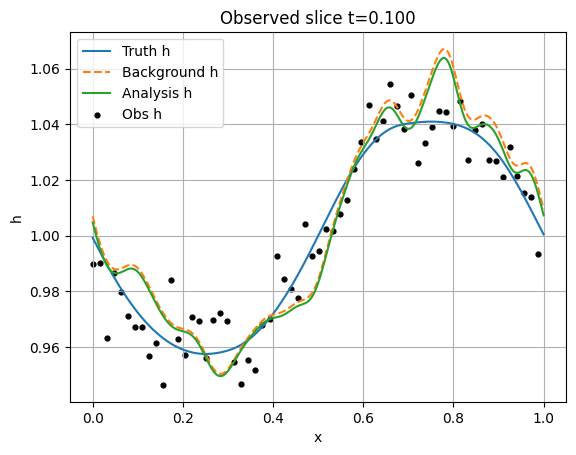

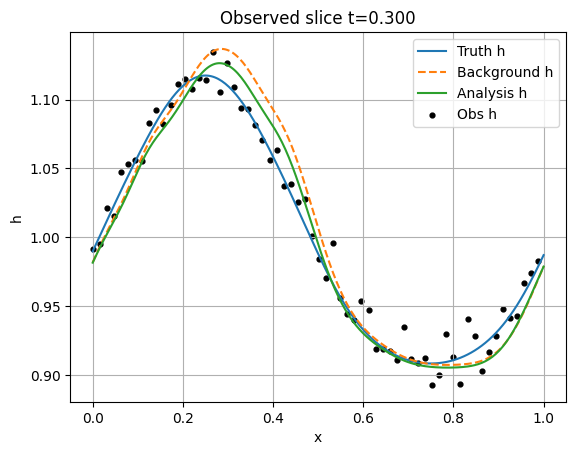

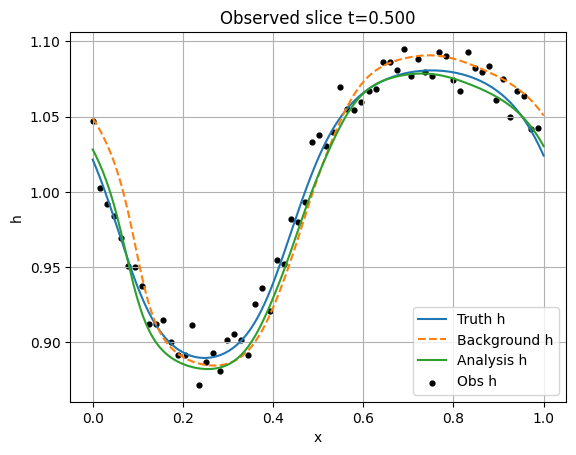

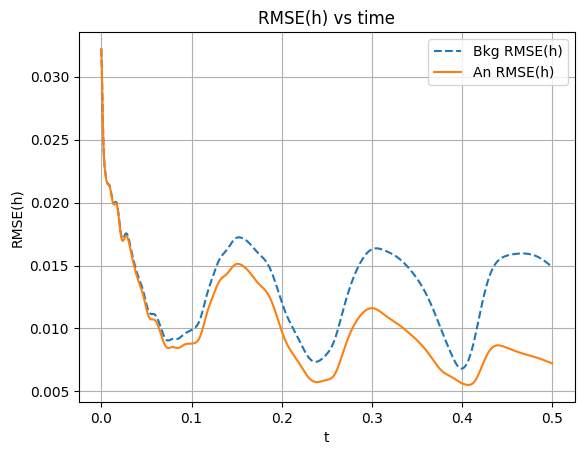

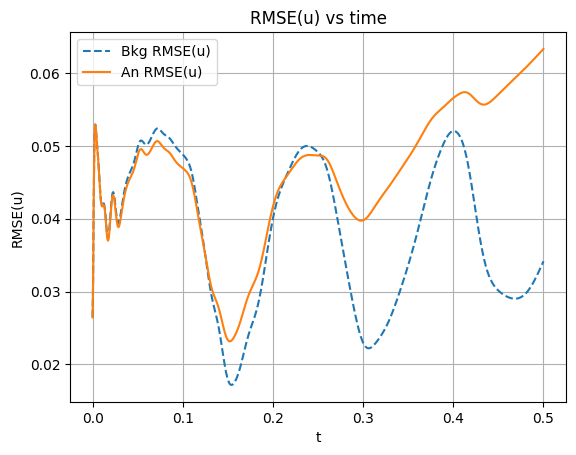

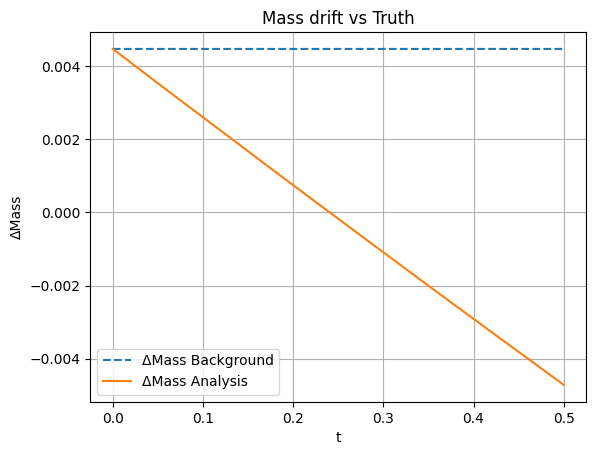

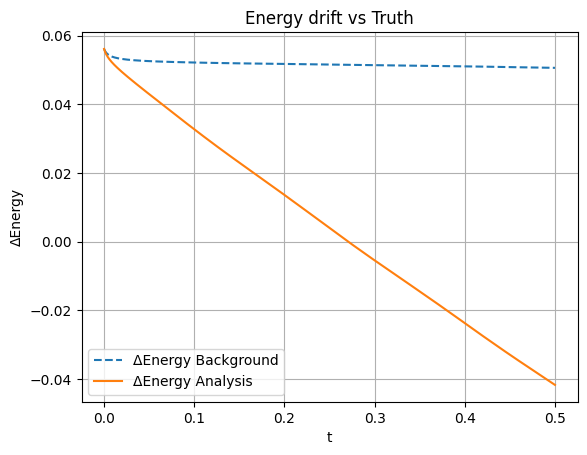

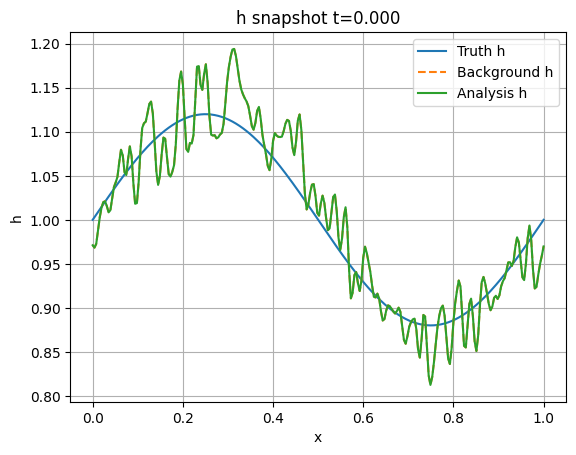

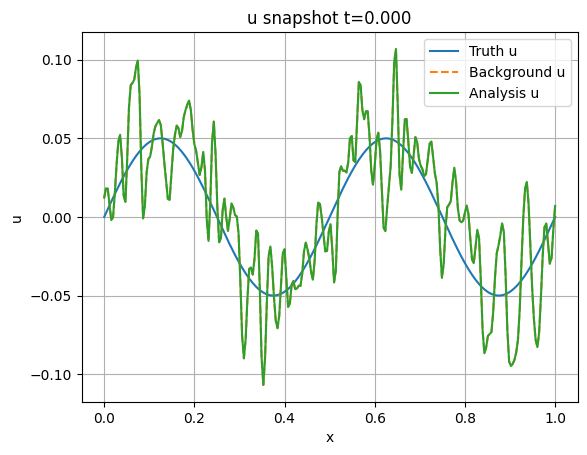

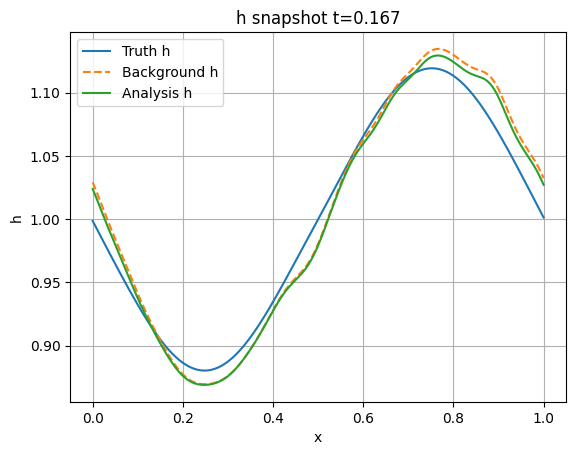

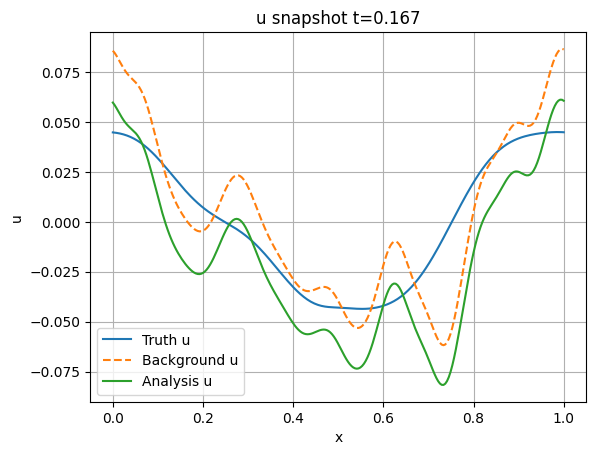

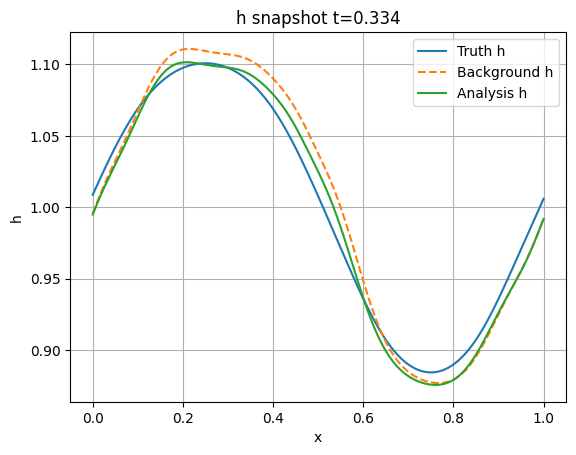

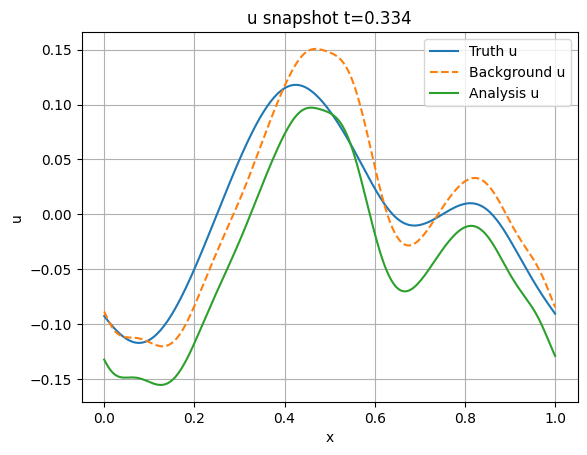

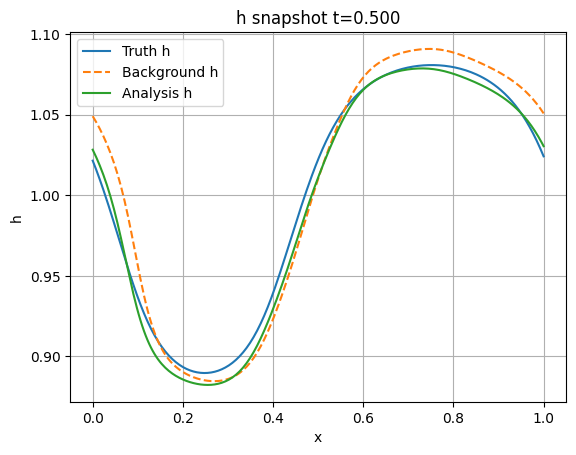

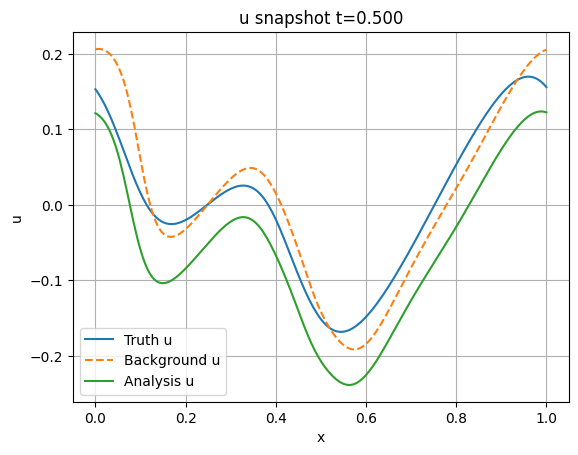

In [1]:
# PINN-assisted 4D-Var (adjoint-free) on 1D Shallow-Water (periodic) — NaN-safe
# -----------------------------------------------------------------------------
import math, numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')

# -------------------- Config --------------------
class CFG:
    L = 1.0; T = 0.5; g = 9.81; CFL = 0.5; Nx = 256
    h0_mean = 1.0; h0_amp = 0.12; u0_amp = 0.05; waves_h = 1; waves_u = 2
    obs_times = [0.1, 0.3, 0.5]; obs_subsample = 4; obs_sigma = 0.01; R_inv = None
    bkg_eps_h = 0.06; bkg_eps_u = 0.06
    epochs = 1200; lr = 1e-3; print_every = 100
    λ_phys = 1.0; λ_obs = 1.0; λ_inc = 1e-5; λ_tv = 1e-5
    h_min = 1e-6       # enforce positive depth
    grad_clip = 1.0    # gradient clipping
cfg = CFG()

# -------------------- Utils --------------------
def roll(a, shift): return torch.roll(a, shifts=shift, dims=-1)
def safe_sqrt(x, eps=1e-8): return torch.sqrt(torch.clamp(x, min=eps))
def safe_div(n, d, eps=1e-8): return n / torch.clamp(d, min=eps)

def ic_truth(x):
    h0 = cfg.h0_mean + cfg.h0_amp * torch.sin(2*math.pi*cfg.waves_h * x / cfg.L)
    u0 = cfg.u0_amp  * torch.sin(2*math.pi*cfg.waves_u * x / cfg.L)
    return h0, u0

def add_perturbation(h0, u0, scale_h, scale_u):
    rnd_h = torch.randn_like(h0); rnd_u = torch.randn_like(u0)
    for _ in range(3):
        rnd_h = 0.5*rnd_h + 0.25*(roll(rnd_h,1)+roll(rnd_h,-1))
        rnd_u = 0.5*rnd_u + 0.25*(roll(rnd_u,1)+roll(rnd_u,-1))
    bh0 = h0 + scale_h * rnd_h
    bu0 = u0 + scale_u * rnd_u
    return bh0, bu0

# -------------------- FD Core (Rusanov) --------------------
def swe_flux(h, u, g):
    hu = h*u
    f1 = hu
    f2 = hu*u + 0.5*g*h*h
    return f1, f2, hu

def rusanov_step(h, u, dx, dt, g):
    hL, hR = h, roll(h, -1)
    uL, uR = u, roll(u, -1)
    f1L, f2L, huL = swe_flux(hL, uL, g)
    f1R, f2R, huR = swe_flux(hR, uR, g)
    s = torch.maximum(torch.abs(uL)+safe_sqrt(g*hL), torch.abs(uR)+safe_sqrt(g*hR))
    F1 = 0.5*(f1L+f1R) - 0.5*s*(hR - hL)
    F2 = 0.5*(f2L+f2R) - 0.5*s*(huR - huL)
    F1L = roll(F1, 1); F2L = roll(F2, 1)
    h_new  = h  - (dt/dx)*(F1 - F1L)
    hu     = h*u
    hu_new = hu - (dt/dx)*(F2 - F2L)
    h_new  = torch.clamp(h_new, min=cfg.h_min)     # keep positive
    u_new  = safe_div(hu_new, h_new)               # safe division
    return h_new, u_new

def make_timegrid_and_dt(Nx, L, T, g, h0, u0, CFL):
    x = torch.linspace(0.0, L, Nx, device=device)
    dx = float(x[1]-x[0])
    c0 = safe_sqrt(g*h0)
    s0 = torch.max(torch.abs(u0)+c0).item()
    dt = CFL * dx / (s0 + 1e-8)
    K = int(np.ceil(T / dt))
    dt = T / K
    tgrid = torch.linspace(0.0, T, K+1, device=device)
    return x, dx, dt, K, tgrid

def forward_core(h0, u0, dx, dt, K):
    H = torch.zeros(K+1, h0.numel(), device=device)
    U = torch.zeros_like(H)
    H[0], U[0] = h0, u0
    h, u = h0.clone(), u0.clone()
    for k in range(K):
        h, u = rusanov_step(h, u, dx, dt, cfg.g)
        H[k+1], U[k+1] = h, u
    return H, U

# -------------------- Discrete physics residual --------------------
def face_fluxes_periodic(h, u, g):
    hL, hR = h, roll(h, -1)
    uL, uR = u, roll(u, -1)
    F1L, F2L, huL = swe_flux(hL, uL, g)
    F1R, F2R, huR = swe_flux(hR, uR, g)
    s = torch.maximum(torch.abs(uL)+safe_sqrt(g*hL), torch.abs(uR)+safe_sqrt(g*hR))
    F1hat = 0.5*(F1L+F1R) - 0.5*s*(hR - hL)
    F2hat = 0.5*(F2L+F2R) - 0.5*s*(huR - huL)
    return F1hat, F2hat

def residual_step(h_t1, u_t1, h_t0, u_t0, dx, dt, g):
    F1, F2 = face_fluxes_periodic(h_t1, u_t1, g)
    F1L = roll(F1, 1); F2L = roll(F2, 1)
    r_h  = (h_t1  - h_t0)/dt           + (F1 - F1L)/dx
    r_hu = (h_t1*u_t1 - h_t0*u_t0)/dt  + (F2 - F2L)/dx
    return r_h, r_hu

# -------------------- Increment network --------------------
class IncrementNet(nn.Module):
    """Small conv net outputs Δh, Δ(hu); outputs bounded with tanh; small initial scale."""
    def __init__(self, width=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(2, width, 3, padding=1, padding_mode='circular'),
            nn.GELU(),
            nn.Conv1d(width, width, 3, padding=1, padding_mode='circular'),
            nn.GELU(),
            nn.Conv1d(width, 2, 1)
        )
        # start small for stability
        self.alpha = nn.Parameter(torch.tensor(0.01))

    def forward(self, h, u):
        x = torch.stack([h, h*u], dim=1)        # [B, 2, N]
        inc = torch.tanh(self.net(x))           # bound increments in [-1,1]
        dh  = self.alpha * inc[:,0]
        dhu = self.alpha * inc[:,1]
        return dh, dhu

def step_with_increment(h, u, dx, dt, net: IncrementNet):
    # core step
    h1, u1 = rusanov_step(h, u, dx, dt, cfg.g)
    # increment
    dh, dhu = net(h1.unsqueeze(0), u1.unsqueeze(0))   # [1,N]
    dh  = dh.squeeze(0);  dhu = dhu.squeeze(0)
    hu1 = h1*u1 + dhu
    h2  = torch.clamp(h1 + dh, min=cfg.h_min)
    u2  = safe_div(hu1, h2)
    return h2, u2, dh, dhu

def roll_with_increment(h0, u0, dx, dt, K, net):
    H = [h0]; U=[u0]; DH=[]; DHU=[]
    h, u = h0.clone(), u0.clone()
    for _ in range(K):
        h, u, dh, dhu = step_with_increment(h, u, dx, dt, net)
        H.append(h); U.append(u); DH.append(dh); DHU.append(dhu)
    H = torch.stack(H, dim=0); U=torch.stack(U, dim=0)
    DH = torch.stack(DH, dim=0); DHU=torch.stack(DHU, dim=0)
    return H, U, DH, DHU

# -------------------- Observations --------------------
def synthesize_observations(H_true, x, tgrid):
    idx_x = torch.arange(0, x.numel(), cfg.obs_subsample, device=device)
    obs = {}; sigma2 = cfg.obs_sigma**2; cfg.R_inv = 1.0/sigma2
    for tval in cfg.obs_times:
        idx_t = int(torch.argmin(torch.abs(tgrid - tval)))
        y = H_true[idx_t][idx_x] + cfg.obs_sigma*torch.randn_like(H_true[idx_t][idx_x])
        obs[idx_t] = {'idx_x': idx_x, 'y': y}
    return obs

def obs_loss(H_pred, obs_dict):
    loss = 0.0
    for t_idx, pack in obs_dict.items():
        idx_x = pack['idx_x']; y = pack['y']
        diff = H_pred[t_idx][idx_x] - y
        loss += cfg.R_inv * (diff*diff).mean()
    return loss

# -------------------- Regularizers --------------------
def increments_regularizer(DH, DHU):
    L2 = (DH**2).mean() + (DHU**2).mean()
    # smoothness across space (last dim)
    tv_h  = (DH - roll(DH,1)).abs().mean()
    tv_hu = (DHU - roll(DHU,1)).abs().mean()
    return cfg.λ_inc*L2 + cfg.λ_tv*(tv_h + tv_hu)

# -------------------- Training --------------------
def train_increment_net(H_bkg, U_bkg, dx, dt, x, tgrid, obs_dict, epochs=1000, lr=1e-3):
    net = IncrementNet(width=64).to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)

    for ep in range(epochs):
        H_an, U_an, DH, DHU = roll_with_increment(H_bkg[0], U_bkg[0], dx, dt, len(tgrid)-1, net)

        # Physics residual across steps
        L_phys = 0.0
        for k in range(1, H_an.shape[0]):
            r_h, r_hu = residual_step(H_an[k], U_an[k], H_an[k-1], U_an[k-1], dx, dt, cfg.g)
            L_phys += (r_h**2).mean() + (r_hu**2).mean()
        L_phys /= (H_an.shape[0]-1)

        # Observation mismatch
        L_obs = obs_loss(H_an, obs_dict)

        # Small/smooth increments
        L_reg = increments_regularizer(DH, DHU)

        loss = cfg.λ_phys*L_phys + cfg.λ_obs*L_obs + L_reg

        # Basic NaN guard (won't trigger now, but safe)
        if torch.isnan(loss):
            print("NaN detected — skipping update"); continue

        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), cfg.grad_clip)
        opt.step()

        if (ep % cfg.print_every)==0 or ep==epochs-1:
            print(f"[ep {ep:04d}] total={loss.item():.3e}  phys={L_phys.item():.2e}  obs={L_obs.item():.2e}  reg={L_reg.item():.2e}")

    return net

# -------------------- Diagnostics --------------------
def rmse(a,b): return torch.sqrt(torch.mean((a-b)**2))
def mass(h, dx):  return torch.sum(h, dim=-1)*dx
def energy(h,u,dx,g): return torch.sum(0.5*h*u*u + 0.5*g*h*h, dim=-1)*dx

def plot_obs_fit(x, tgrid, obs, H_true, H_bkg, H_an):
    for tval in cfg.obs_times:
        idx_t = int(torch.argmin(torch.abs(tgrid - tval)))
        plt.figure()
        plt.plot(x.detach().cpu(), H_true[idx_t].detach().cpu(), label='Truth h')
        plt.plot(x.detach().cpu(), H_bkg[idx_t].detach().cpu(), '--', label='Background h')
        plt.plot(x.detach().cpu(), H_an[idx_t].detach().cpu(),   label='Analysis h')
        dd = obs[idx_t]; plt.scatter(x[dd['idx_x']].detach().cpu(), dd['y'].detach().cpu(), s=12, c='k', label='Obs h')
        plt.title(f'Observed slice t={tgrid[idx_t].item():.3f}')
        plt.xlabel('x'); plt.ylabel('h'); plt.legend(); plt.grid(True); plt.show()

def plot_rmse_time(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an):
    Nt = H_true.shape[0]
    r_h_b = [rmse(H_bkg[j], H_true[j]).item() for j in range(Nt)]
    r_u_b = [rmse(U_bkg[j], U_true[j]).item() for j in range(Nt)]
    r_h_a = [rmse(H_an[j],  H_true[j]).item() for j in range(Nt)]
    r_u_a = [rmse(U_an[j],  U_true[j]).item() for j in range(Nt)]
    t = tgrid.detach().cpu().numpy()
    plt.figure(); plt.plot(t, r_h_b, '--', label='Bkg RMSE(h)'); plt.plot(t, r_h_a, label='An RMSE(h)')
    plt.xlabel('t'); plt.ylabel('RMSE(h)'); plt.grid(True); plt.legend(); plt.title('RMSE(h) vs time'); plt.show()
    plt.figure(); plt.plot(t, r_u_b, '--', label='Bkg RMSE(u)'); plt.plot(t, r_u_a, label='An RMSE(u)')
    plt.xlabel('t'); plt.ylabel('RMSE(u)'); plt.grid(True); plt.legend(); plt.title('RMSE(u) vs time'); plt.show()

def plot_budget_drifts(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an, dx, g):
    t = tgrid.detach().cpu().numpy()
    m_tr = torch.stack([mass(H_true[j], dx) for j in range(H_true.shape[0])]).detach().cpu().numpy()
    m_bk = torch.stack([mass(H_bkg[j], dx)  for j in range(H_true.shape[0])]).detach().cpu().numpy()
    m_an = torch.stack([mass(H_an[j], dx)   for j in range(H_true.shape[0])]).detach().cpu().numpy()
    e_tr = torch.stack([energy(H_true[j], U_true[j], dx, g) for j in range(H_true.shape[0])]).detach().cpu().numpy()
    e_bk = torch.stack([energy(H_bkg[j], U_bkg[j], dx, g)  for j in range(H_true.shape[0])]).detach().cpu().numpy()
    e_an = torch.stack([energy(H_an[j], U_an[j], dx, g)    for j in range(H_true.shape[0])]).detach().cpu().numpy()
    plt.figure(); plt.plot(t, m_bk-m_tr, '--', label='ΔMass Background'); plt.plot(t, m_an-m_tr, label='ΔMass Analysis')
    plt.xlabel('t'); plt.ylabel('ΔMass'); plt.grid(True); plt.legend(); plt.title('Mass drift vs Truth'); plt.show()
    plt.figure(); plt.plot(t, e_bk-e_tr, '--', label='ΔEnergy Background'); plt.plot(t, e_an-e_tr, label='ΔEnergy Analysis')
    plt.xlabel('t'); plt.ylabel('ΔEnergy'); plt.grid(True); plt.legend(); plt.title('Energy drift vs Truth'); plt.show()

def plot_snapshots(x, tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an):
    Nt = H_true.shape[0]
    for j in [0, Nt//3, 2*Nt//3, Nt-1]:
        plt.figure(); plt.plot(x.detach().cpu(), H_true[j].detach().cpu(), label='Truth h')
        plt.plot(x.detach().cpu(), H_bkg[j].detach().cpu(), '--', label='Background h')
        plt.plot(x.detach().cpu(), H_an[j].detach().cpu(), label='Analysis h')
        plt.xlabel('x'); plt.ylabel('h'); plt.title(f'h snapshot t={tgrid[j].item():.3f}'); plt.legend(); plt.grid(True); plt.show()
        plt.figure(); plt.plot(x.detach().cpu(), U_true[j].detach().cpu(), label='Truth u')
        plt.plot(x.detach().cpu(), U_bkg[j].detach().cpu(), '--', label='Background u')
        plt.plot(x.detach().cpu(), U_an[j].detach().cpu(), label='Analysis u')
        plt.xlabel('x'); plt.ylabel('u'); plt.title(f'u snapshot t={tgrid[j].item():.3f}'); plt.legend(); plt.grid(True); plt.show()

# -------------------- Main --------------------
def main():
    torch.manual_seed(0); np.random.seed(0)
    # Truth
    x = torch.linspace(0.0, cfg.L, cfg.Nx, device=device)
    h0_tr, u0_tr = ic_truth(x)
    x, dx, dt, K, tgrid = make_timegrid_and_dt(cfg.Nx, cfg.L, cfg.T, cfg.g, h0_tr, u0_tr, cfg.CFL)
    H_true, U_true = forward_core(h0_tr, u0_tr, dx, dt, K)

    # Observations
    obs = synthesize_observations(H_true, x, tgrid)

    # Background (perturbed) and forecast
    h0_bk, u0_bk = add_perturbation(h0_tr, u0_tr, cfg.bkg_eps_h, cfg.bkg_eps_u)
    # Ensure positive background depth
    h0_bk = torch.clamp(h0_bk, min=cfg.h_min)
    H_bkg, U_bkg = forward_core(h0_bk, u0_bk, dx, dt, K)

    # Train increment net
    net = train_increment_net(H_bkg, U_bkg, dx, dt, x, tgrid, obs,
                              epochs=cfg.epochs, lr=cfg.lr)

    # Analysis rollout with trained net
    H_an, U_an, DH, DHU = roll_with_increment(H_bkg[0], U_bkg[0], dx, dt, K, net)

    # Diagnostics
    plot_obs_fit(x, tgrid, obs, H_true, H_bkg, H_an)
    plot_rmse_time(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an)
    plot_budget_drifts(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an, dx, cfg.g)
    plot_snapshots(x, tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an)

if __name__ == "__main__":
    main()


# Corrected code

[ep 0000] total=1.433e+01  phys_h=8.14e-02  phys_hu=1.14e+00  obs=1.08e+01  cont=1.86e-04  reg=5.60e-11
[ep 0100] total=6.602e+00  phys_h=5.08e-02  phys_hu=4.54e-01  obs=5.19e+00  cont=4.99e-04  reg=7.76e-07
[ep 0200] total=5.027e+00  phys_h=4.37e-02  phys_hu=1.86e-01  obs=4.43e+00  cont=5.08e-04  reg=7.19e-07
[ep 0300] total=4.943e+00  phys_h=4.18e-02  phys_hu=1.64e-01  obs=4.41e+00  cont=5.49e-04  reg=6.93e-07
[ep 0400] total=4.858e+00  phys_h=3.78e-02  phys_hu=1.39e-01  obs=4.40e+00  cont=6.41e-04  reg=6.16e-07
[ep 0500] total=4.795e+00  phys_h=3.41e-02  phys_hu=1.20e-01  obs=4.40e+00  cont=8.86e-04  reg=3.77e-07
[ep 0600] total=4.723e+00  phys_h=3.06e-02  phys_hu=1.07e-01  obs=4.37e+00  cont=1.18e-03  reg=8.01e-07
[ep 0700] total=4.606e+00  phys_h=2.90e-02  phys_hu=8.46e-02  obs=4.32e+00  cont=1.41e-03  reg=9.89e-07
[ep 0800] total=4.547e+00  phys_h=2.75e-02  phys_hu=7.52e-02  obs=4.29e+00  cont=1.59e-03  reg=9.01e-07
[ep 0900] total=4.543e+00  phys_h=2.68e-02  phys_hu=6.93e-02  ob

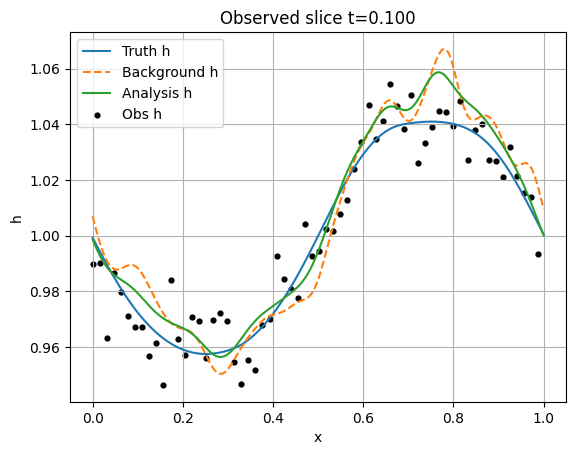

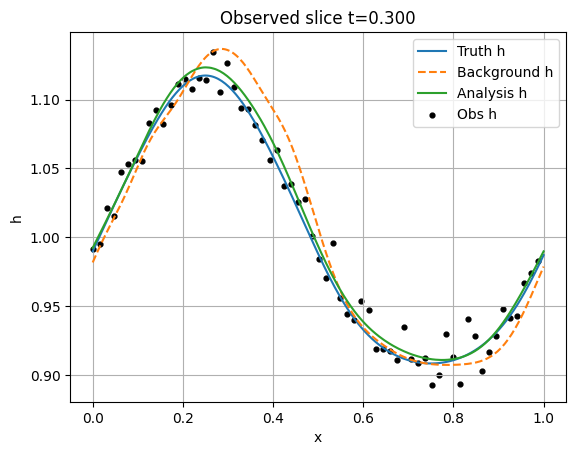

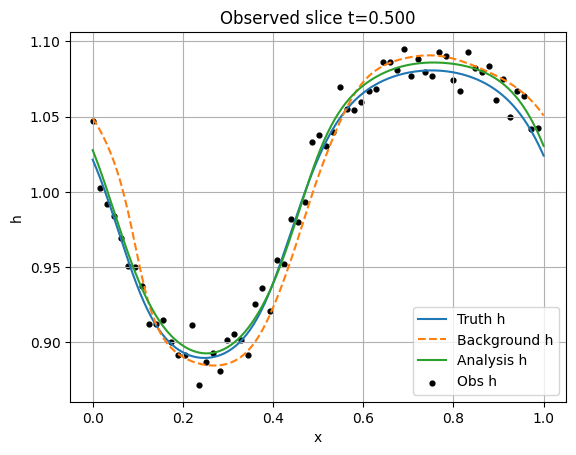

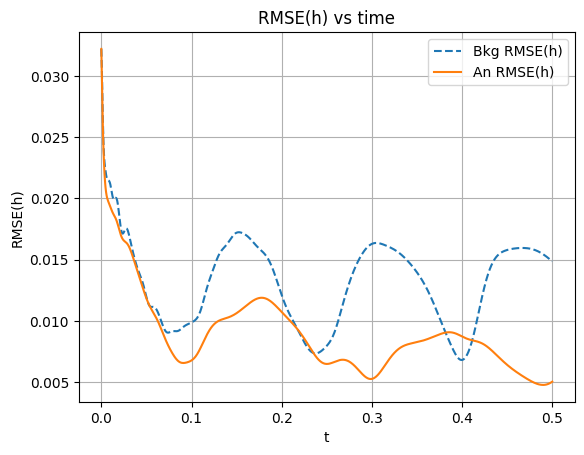

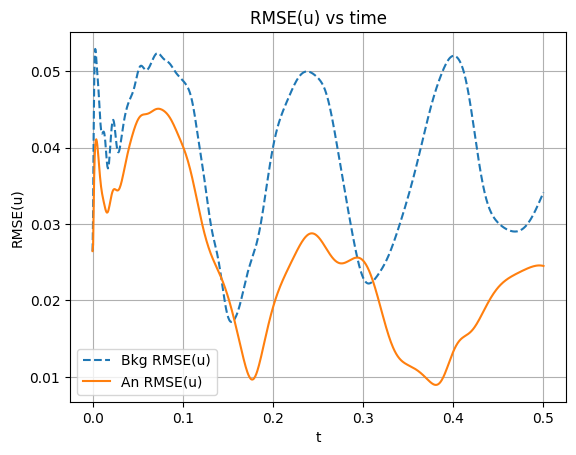

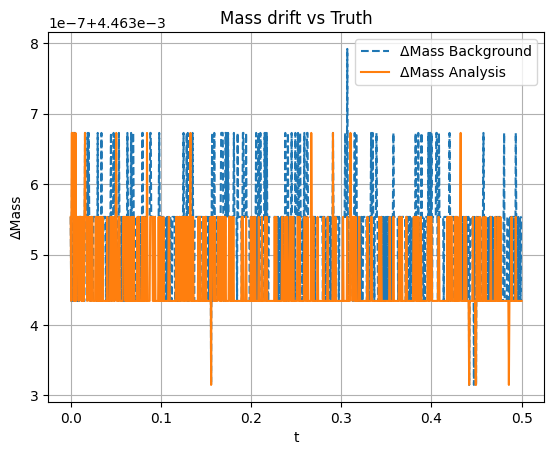

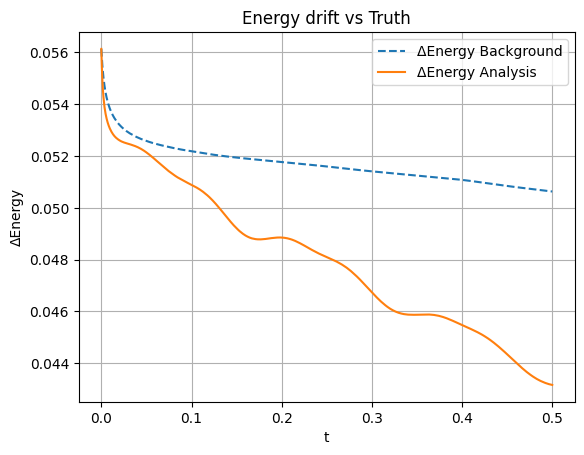

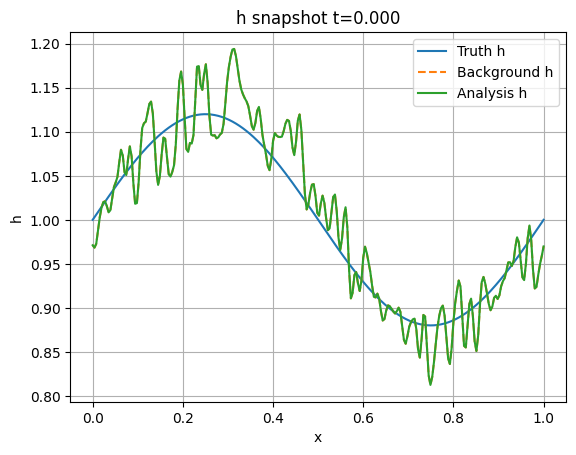

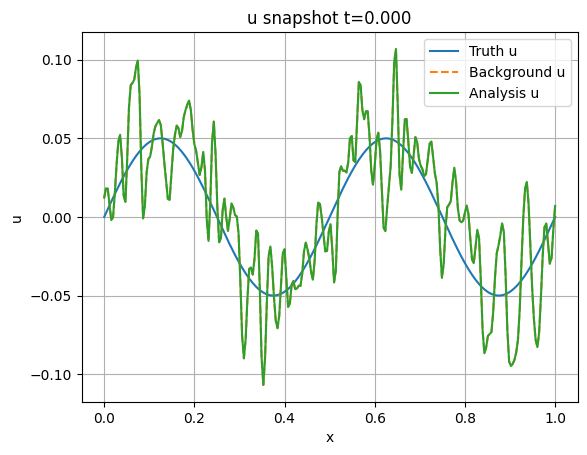

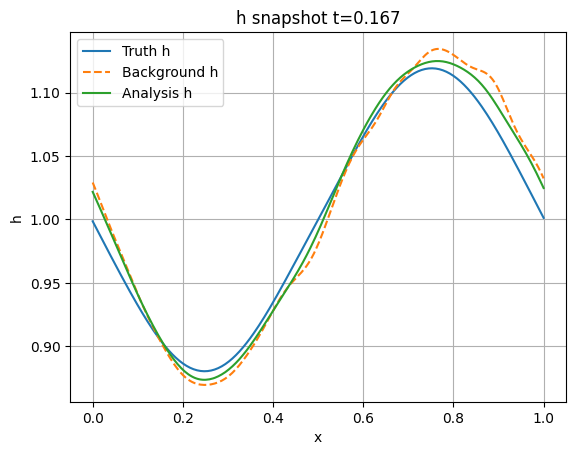

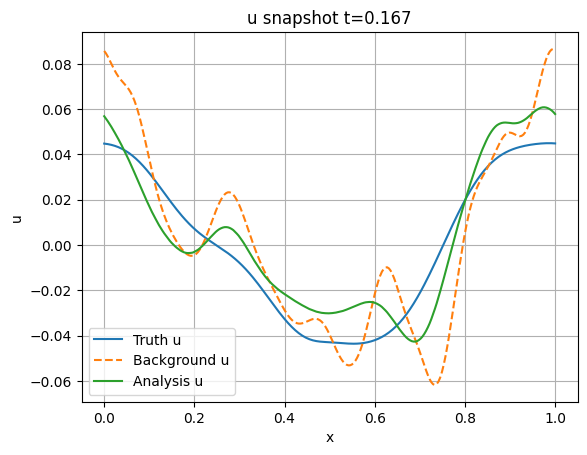

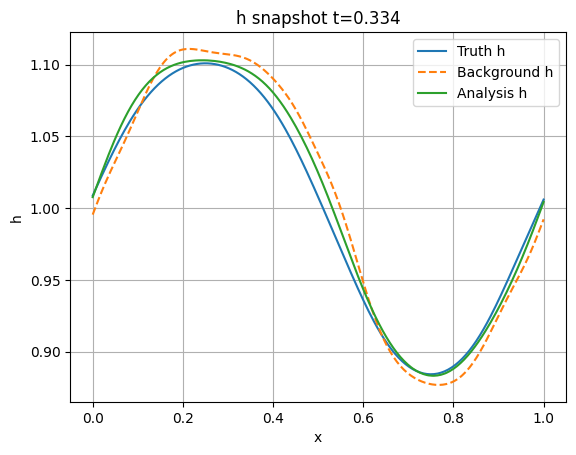

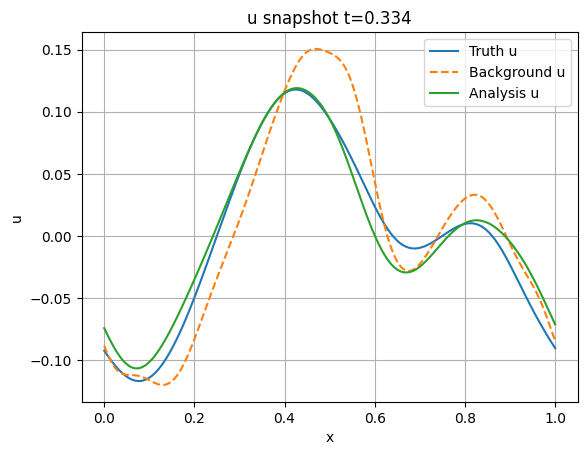

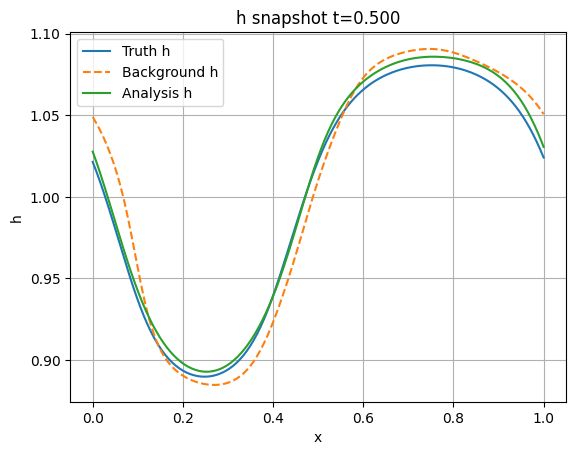

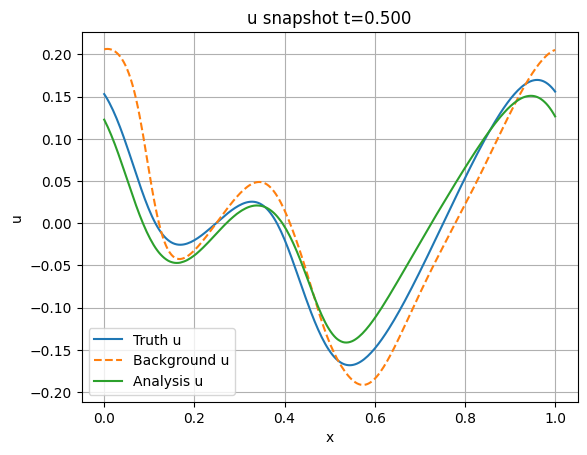

In [1]:
# PINN-assisted 4D-Var on 1D Shallow-Water (periodic)
# Flux-form increments + split physics weights + continuity slice loss (no AD)
# ---------------------------------------------------------------------------

import math, numpy as np
import torch, torch.nn as nn
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('high')

# ========================= Config =========================
class CFG:
    # Domain & physics
    L = 1.0
    T = 0.5
    g = 9.81
    CFL = 0.5
    Nx = 256

    # Truth IC
    h0_mean = 1.0
    h0_amp  = 0.12
    u0_amp  = 0.05
    waves_h = 1
    waves_u = 2

    # Observations (h only)
    obs_times = [0.1, 0.3, 0.5]
    obs_subsample = 4
    obs_sigma = 0.01
    R_inv = None

    # Background IC perturbation
    bkg_eps_h = 0.06
    bkg_eps_u = 0.06

    # Training
    epochs = 1500
    lr = 1e-3
    print_every = 100
    grad_clip = 1.0

    # Loss weights
    λ_phys_h  = 1.0    # continuity residual weight
    λ_phys_hu = 3.0    # momentum residual weight (stronger)
    λ_obs     = 1.0
    λ_inc_L2  = 1e-6   # L2 on flux corrections
    λ_inc_TV  = 1e-5   # TV smoothness on flux corrections
    λ_cons    = 5e-4   # small conservation helper (mass mean & KE work)
    λ_cont    = 0.2    # continuity slice helper at observed times

    # Numerics
    h_min = 1e-6

cfg = CFG()

# ========================= Utilities =========================
def roll(a, shift): return torch.roll(a, shifts=shift, dims=-1)
def safe_sqrt(x, eps=1e-8): return torch.sqrt(torch.clamp(x, min=eps))
def safe_div(n, d, eps=1e-8): return n / torch.clamp(d, min=eps)

def centered_dx(v, dx):
    return (roll(v, -1) - roll(v, 1)) / (2.0*dx)

def ic_truth(x):
    h0 = cfg.h0_mean + cfg.h0_amp * torch.sin(2*math.pi*cfg.waves_h * x / cfg.L)
    u0 = cfg.u0_amp  * torch.sin(2*math.pi*cfg.waves_u * x / cfg.L)
    return h0, u0

def add_perturbation(h0, u0, scale_h, scale_u):
    rnd_h = torch.randn_like(h0); rnd_u = torch.randn_like(u0)
    for _ in range(3):  # smooth them a bit
        rnd_h = 0.5*rnd_h + 0.25*(roll(rnd_h,1)+roll(rnd_h,-1))
        rnd_u = 0.5*rnd_u + 0.25*(roll(rnd_u,1)+roll(rnd_u,-1))
    bh0 = torch.clamp(h0 + scale_h * rnd_h, min=cfg.h_min)
    bu0 = u0 + scale_u * rnd_u
    return bh0, bu0

# ========================= FD Core (Rusanov) =========================
def swe_flux(h, u, g):
    hu = h*u
    f1 = hu
    f2 = hu*u + 0.5*g*h*h
    return f1, f2, hu

def rusanov_step(h, u, dx, dt, g):
    hL, hR = h, roll(h, -1)
    uL, uR = u, roll(u, -1)
    f1L, f2L, huL = swe_flux(hL, uL, g)
    f1R, f2R, huR = swe_flux(hR, uR, g)
    s = torch.maximum(torch.abs(uL)+safe_sqrt(g*hL), torch.abs(uR)+safe_sqrt(g*hR))
    F1 = 0.5*(f1L+f1R) - 0.5*s*(hR - hL)
    F2 = 0.5*(f2L+f2R) - 0.5*s*(huR - huL)
    F1L = roll(F1, 1); F2L = roll(F2, 1)
    h_new  = torch.clamp(h  - (dt/dx)*(F1 - F1L), min=cfg.h_min)
    hu     = h*u
    hu_new = hu - (dt/dx)*(F2 - F2L)
    u_new  = safe_div(hu_new, h_new)
    return h_new, u_new

def make_timegrid_and_dt(Nx, L, T, g, h0, u0, CFL):
    x = torch.linspace(0.0, L, Nx, device=device)
    dx = float(x[1]-x[0])
    c0 = safe_sqrt(g*h0)
    s0 = torch.max(torch.abs(u0)+c0).item()
    dt = CFL * dx / (s0 + 1e-8)
    K  = int(np.ceil(T / dt))
    dt = T / K
    tgrid = torch.linspace(0.0, T, K+1, device=device)
    return x, dx, dt, K, tgrid

def forward_core(h0, u0, dx, dt, K):
    H = torch.zeros(K+1, h0.numel(), device=device)
    U = torch.zeros_like(H)
    H[0], U[0] = h0, u0
    h, u = h0.clone(), u0.clone()
    for k in range(K):
        h, u = rusanov_step(h, u, dx, dt, cfg.g)
        H[k+1], U[k+1] = h, u
    return H, U

# ========================= Discrete residuals =========================
def face_fluxes_periodic(h, u, g):
    hL, hR = h, roll(h, -1)
    uL, uR = u, roll(u, -1)
    F1L, F2L, huL = swe_flux(hL, uL, g)
    F1R, F2R, huR = swe_flux(hR, uR, g)
    s = torch.maximum(torch.abs(uL)+safe_sqrt(g*hL), torch.abs(uR)+safe_sqrt(g*hR))
    F1hat = 0.5*(F1L+F1R) - 0.5*s*(hR - hL)
    F2hat = 0.5*(F2L+F2R) - 0.5*s*(huR - huL)
    return F1hat, F2hat

def residual_step(h_t1, u_t1, h_t0, u_t0, dx, dt, g):
    F1, F2 = face_fluxes_periodic(h_t1, u_t1, g)
    F1L = roll(F1, 1); F2L = roll(F2, 1)
    r_h  = (h_t1  - h_t0)/dt           + (F1 - F1L)/dx
    r_hu = (h_t1*u_t1 - h_t0*u_t0)/dt  + (F2 - F2L)/dx
    return r_h, r_hu

# ========================= Increment net (Flux-form) =========================
class IncrementNet(nn.Module):
    """
    Predicts corrections to mass/momentum flux (cell-centered proxies) -> applied via divergence.
    This yields mass-neutral increments (with periodic BC).
    """
    def __init__(self, width=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(2, width, 3, padding=1, padding_mode='circular'),
            nn.GELU(),
            nn.Conv1d(width, width, 3, padding=1, padding_mode='circular'),
            nn.GELU(),
            nn.Conv1d(width, 2, 1)
        )
        self.alpha = nn.Parameter(torch.tensor(0.01))  # small stable scale

    def forward(self, h, u):
        x = torch.stack([h, h*u], dim=1)        # [B, 2, N] features: h and hu
        raw = torch.tanh(self.net(x))           # bound to [-1,1]
        F1corr = self.alpha * raw[:,0]          # mass-flux correction proxy
        F2corr = self.alpha * raw[:,1]          # momentum-flux correction proxy
        return F1corr, F2corr

def div_from_centered_proxy(Fc, dx):
    # map cell-centered proxy to right faces by averaging, then divergence
    Fr = 0.5 * (Fc + roll(Fc, -1))   # to right face
    Fl = roll(Fr, 1)
    return (Fr - Fl) / dx

def step_with_increment(h, u, dx, dt, net: IncrementNet):
    # (1) Core step
    h1, u1 = rusanov_step(h, u, dx, dt, cfg.g)
    hu1 = h1*u1

    # (2) Flux corrections (batch)
    F1c, F2c = net(h1.unsqueeze(0), u1.unsqueeze(0))
    F1c = F1c.squeeze(0); F2c = F2c.squeeze(0)

    # (3) Conservative update: q^{n+1} = q^{n+1}_core - dt * div(Fcorr)
    h2  = torch.clamp(h1  - dt * div_from_centered_proxy(F1c, dx), min=cfg.h_min)
    hu2 =          hu1 - dt * div_from_centered_proxy(F2c, dx)
    u2  = safe_div(hu2, h2)

    return h2, u2, F1c, F2c

def roll_with_increment(h0, u0, dx, dt, K, net):
    H=[h0]; U=[u0]; F1C=[]; F2C=[]
    h, u = h0.clone(), u0.clone()
    for _ in range(K):
        h, u, f1c, f2c = step_with_increment(h, u, dx, dt, net)
        H.append(h); U.append(u); F1C.append(f1c); F2C.append(f2c)
    H = torch.stack(H,  dim=0)
    U = torch.stack(U,  dim=0)
    F1C = torch.stack(F1C, dim=0)
    F2C = torch.stack(F2C, dim=0)
    return H, U, F1C, F2C

# ========================= Observations & Losses =========================
def synthesize_observations(H_true, x, tgrid):
    idx_x = torch.arange(0, x.numel(), cfg.obs_subsample, device=device)
    obs = {}
    sigma2 = cfg.obs_sigma**2
    cfg.R_inv = 1.0/sigma2
    for tval in cfg.obs_times:
        idx_t = int(torch.argmin(torch.abs(tgrid - tval)))
        y = H_true[idx_t][idx_x] + cfg.obs_sigma*torch.randn_like(H_true[idx_t][idx_x])
        obs[idx_t] = {'idx_x': idx_x, 'y': y}
    return obs

def obs_loss(H_pred, obs_dict, tgrid):
    loss = 0.0
    for t_idx, pack in obs_dict.items():
        idx_x = pack['idx_x']; y = pack['y']
        diff = H_pred[t_idx][idx_x] - y
        w = 2.0 if t_idx == int(torch.argmin(torch.abs(tgrid - cfg.T))) else 1.0  # slightly up-weight last slice
        loss += w * cfg.R_inv * (diff*diff).mean()
    return loss

def increments_regularizer(F1C, F2C):
    L2 = (F1C**2).mean() + (F2C**2).mean()
    TV = (F1C - roll(F1C,1)).abs().mean() + (F2C - roll(F2C,1)).abs().mean()
    return cfg.λ_inc_L2*L2 + cfg.λ_inc_TV*TV

def conservation_regularizer(h, u, F1c, F2c, dx):
    mass_mean = torch.mean(F1c)
    ke_work   = torch.mean(u * div_from_centered_proxy(F2c, dx))
    return cfg.λ_cons * (mass_mean**2 + 0.1*ke_work**2)

def continuity_slice_loss_noAD(H_an, U_an, obs_dict, dx, dt):
    loss = 0.0; n=0
    for t_idx in obs_dict.keys():
        if 1 <= t_idx < H_an.shape[0]-1:
            ht  = (H_an[t_idx+1]-H_an[t_idx-1])/(2*dt)
            hux = centered_dx(H_an[t_idx]*U_an[t_idx], dx)
            loss += ((ht + hux)**2).mean()
            n += 1
    return cfg.λ_cont * (loss/(n if n>0 else 1.0))

# ========================= Training =========================
def train_increment_net(H_bkg, U_bkg, dx, dt, x, tgrid, obs_dict, epochs=1500, lr=1e-3):
    net = IncrementNet(width=64).to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr)

    for ep in range(epochs):
        H_an, U_an, F1C, F2C = roll_with_increment(H_bkg[0], U_bkg[0], dx, dt, len(tgrid)-1, net)

        # Discrete physics residuals (split)
        L_h  = 0.0
        L_hu = 0.0
        for k in range(1, H_an.shape[0]):
            r_h, r_hu = residual_step(H_an[k], U_an[k], H_an[k-1], U_an[k-1], dx, dt, cfg.g)
            L_h  += (r_h**2).mean()
            L_hu += (r_hu**2).mean()
        L_h  /= (H_an.shape[0]-1)
        L_hu /= (H_an.shape[0]-1)

        # Observation mismatch
        L_obs = obs_loss(H_an, obs_dict, tgrid)

        # Increment regularization + small conservation helper (use the last-step corrections)
        L_reg = increments_regularizer(F1C, F2C) + conservation_regularizer(H_an[-1], U_an[-1], F1C[-1], F2C[-1], dx)

        # Continuity slice coupling at observed times (no AD)
        L_cont = continuity_slice_loss_noAD(H_an, U_an, obs_dict, dx, dt)

        loss = cfg.λ_phys_h*L_h + cfg.λ_phys_hu*L_hu + cfg.λ_obs*L_obs + L_reg + L_cont

        if torch.isnan(loss):
            print("NaN detected; skipping update"); continue

        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), cfg.grad_clip)
        opt.step()

        if (ep % cfg.print_every)==0 or ep==epochs-1:
            print(f"[ep {ep:04d}] total={loss.item():.3e}  phys_h={L_h.item():.2e}  phys_hu={L_hu.item():.2e}  "
                  f"obs={L_obs.item():.2e}  cont={L_cont.item():.2e}  reg={L_reg.item():.2e}")

    return net

# ========================= Diagnostics =========================
def rmse(a,b): return torch.sqrt(torch.mean((a-b)**2))
def mass(h, dx):  return torch.sum(h, dim=-1)*dx
def energy(h,u,dx,g): return torch.sum(0.5*h*u*u + 0.5*g*h*h, dim=-1)*dx

def plot_obs_fit(x, tgrid, obs, H_true, H_bkg, H_an):
    for tval in cfg.obs_times:
        idx_t = int(torch.argmin(torch.abs(tgrid - tval)))
        plt.figure()
        plt.plot(x.detach().cpu(), H_true[idx_t].detach().cpu(), label='Truth h')
        plt.plot(x.detach().cpu(), H_bkg[idx_t].detach().cpu(), '--', label='Background h')
        plt.plot(x.detach().cpu(), H_an[idx_t].detach().cpu(),   label='Analysis h')
        dd = obs[idx_t]
        plt.scatter(x[dd['idx_x']].detach().cpu(), dd['y'].detach().cpu(), s=12, c='k', label='Obs h')
        plt.title(f'Observed slice t={tgrid[idx_t].item():.3f}')
        plt.xlabel('x'); plt.ylabel('h'); plt.legend(); plt.grid(True); plt.show()

def plot_rmse_time(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an):
    Nt = H_true.shape[0]
    r_h_b = [rmse(H_bkg[j], H_true[j]).item() for j in range(Nt)]
    r_u_b = [rmse(U_bkg[j], U_true[j]).item() for j in range(Nt)]
    r_h_a = [rmse(H_an[j],  H_true[j]).item() for j in range(Nt)]
    r_u_a = [rmse(U_an[j],  U_true[j]).item() for j in range(Nt)]
    t = tgrid.detach().cpu().numpy()
    plt.figure(); plt.plot(t, r_h_b, '--', label='Bkg RMSE(h)'); plt.plot(t, r_h_a, label='An RMSE(h)')
    plt.xlabel('t'); plt.ylabel('RMSE(h)'); plt.grid(True); plt.legend(); plt.title('RMSE(h) vs time'); plt.show()
    plt.figure(); plt.plot(t, r_u_b, '--', label='Bkg RMSE(u)'); plt.plot(t, r_u_a, label='An RMSE(u)')
    plt.xlabel('t'); plt.ylabel('RMSE(u)'); plt.grid(True); plt.legend(); plt.title('RMSE(u) vs time'); plt.show()

def plot_budget_drifts(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an, dx, g):
    t = tgrid.detach().cpu().numpy()
    m_tr = torch.stack([mass(H_true[j], dx) for j in range(H_true.shape[0])]).detach().cpu().numpy()
    m_bk = torch.stack([mass(H_bkg[j], dx)  for j in range(H_true.shape[0])]).detach().cpu().numpy()
    m_an = torch.stack([mass(H_an[j],  dx)  for j in range(H_true.shape[0])]).detach().cpu().numpy()
    e_tr = torch.stack([energy(H_true[j], U_true[j], dx, g) for j in range(H_true.shape[0])]).detach().cpu().numpy()
    e_bk = torch.stack([energy(H_bkg[j], U_bkg[j], dx, g)  for j in range(H_true.shape[0])]).detach().cpu().numpy()
    e_an = torch.stack([energy(H_an[j],  U_an[j],  dx, g)  for j in range(H_true.shape[0])]).detach().cpu().numpy()
    plt.figure(); plt.plot(t, m_bk-m_tr, '--', label='ΔMass Background'); plt.plot(t, m_an-m_tr, label='ΔMass Analysis')
    plt.xlabel('t'); plt.ylabel('ΔMass'); plt.grid(True); plt.legend(); plt.title('Mass drift vs Truth'); plt.show()
    plt.figure(); plt.plot(t, e_bk-e_tr, '--', label='ΔEnergy Background'); plt.plot(t, e_an-e_tr, label='ΔEnergy Analysis')
    plt.xlabel('t'); plt.ylabel('ΔEnergy'); plt.grid(True); plt.legend(); plt.title('Energy drift vs Truth'); plt.show()

def plot_snapshots(x, tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an):
    Nt = H_true.shape[0]
    for j in [0, Nt//3, 2*Nt//3, Nt-1]:
        plt.figure(); plt.plot(x.detach().cpu(), H_true[j].detach().cpu(), label='Truth h')
        plt.plot(x.detach().cpu(), H_bkg[j].detach().cpu(), '--', label='Background h')
        plt.plot(x.detach().cpu(), H_an[j].detach().cpu(), label='Analysis h')
        plt.xlabel('x'); plt.ylabel('h'); plt.title(f'h snapshot t={tgrid[j].item():.3f}'); plt.legend(); plt.grid(True); plt.show()
        plt.figure(); plt.plot(x.detach().cpu(), U_true[j].detach().cpu(), label='Truth u')
        plt.plot(x.detach().cpu(), U_bkg[j].detach().cpu(), '--', label='Background u')
        plt.plot(x.detach().cpu(), U_an[j].detach().cpu(), label='Analysis u')
        plt.xlabel('x'); plt.ylabel('u'); plt.title(f'u snapshot t={tgrid[j].item():.3f}'); plt.legend(); plt.grid(True); plt.show()

# ========================= Main =========================
def main():
    torch.manual_seed(0); np.random.seed(0)

    # Truth
    x = torch.linspace(0.0, cfg.L, cfg.Nx, device=device)
    h0_tr, u0_tr = ic_truth(x)
    x, dx, dt, K, tgrid = make_timegrid_and_dt(cfg.Nx, cfg.L, cfg.T, cfg.g, h0_tr, u0_tr, cfg.CFL)
    H_true, U_true = forward_core(h0_tr, u0_tr, dx, dt, K)

    # Observations from truth
    obs = synthesize_observations(H_true, x, tgrid)

    # Background (perturbed) forecast
    h0_bk, u0_bk = add_perturbation(h0_tr, u0_tr, cfg.bkg_eps_h, cfg.bkg_eps_u)
    H_bkg, U_bkg = forward_core(h0_bk, u0_bk, dx, dt, K)

    # Train increment net (flux-form + split physics + continuity slice)
    net = train_increment_net(H_bkg, U_bkg, dx, dt, x, tgrid, obs, epochs=cfg.epochs, lr=cfg.lr)

    # Final analysis rollout
    H_an, U_an, F1C, F2C = roll_with_increment(H_bkg[0], U_bkg[0], dx, dt, K, net)

    # Diagnostics
    plot_obs_fit(x, tgrid, obs, H_true, H_bkg, H_an)
    plot_rmse_time(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an)
    plot_budget_drifts(tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an, dx, cfg.g)
    plot_snapshots(x, tgrid, H_true, U_true, H_bkg, U_bkg, H_an, U_an)

if __name__ == "__main__":
    main()
